# Data and Imports

In [1]:



import pandas as pd
import numpy as np
import jsonlines
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch_optimizer as optim


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from importlib import reload
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', '{:0.3f}'.format)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.width = 0
import warnings
import torchvision
warnings.filterwarnings('ignore')

from facebook_hateful_memes_detector.utils.globals import set_global, get_global
set_global("cache_dir", "/home/ahemf/cache/cache")
set_global("dataloader_workers", 4)
set_global("use_autocast", True)
set_global("models_dir", "/home/ahemf/cache/")

from facebook_hateful_memes_detector.utils import read_json_lines_into_df, in_notebook, set_device
get_global("cache_dir")
from facebook_hateful_memes_detector.models import Fasttext1DCNNModel, MultiImageMultiTextAttentionEarlyFusionModel, LangFeaturesModel, AlbertClassifer
from facebook_hateful_memes_detector.preprocessing import TextImageDataset, my_collate, get_datasets, get_image2torchvision_transforms, TextAugment
from facebook_hateful_memes_detector.preprocessing import DefinedRotation, QuadrantCut, ImageAugment
from facebook_hateful_memes_detector.training import *
import facebook_hateful_memes_detector
reload(facebook_hateful_memes_detector)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_device(device)
device


device(type='cuda')

- What Augs are useful
- What Text models perform best

In [27]:


choice_probas = {"keyboard": 0.1, "char_substitute": 0.0, "char_insert": 0.1, "char_swap": 0.1, "ocr": 0.0, "char_delete": 0.1,
                 "fasttext": 0.0, "glove_twitter": 0.0, "glove_wiki": 0.0, "word2vec": 0.0, "split": 0.1,
                 "stopword_insert": 0.3, "word_join": 0.1, "word_cutout": 0.8,
                 "text_rotate": 0.0, "sentence_shuffle": 0.5, "one_third_cut": 0.3, "half_cut":0.0}
preprocess_text = TextAugment([0.05, 0.05, 0.05, 0.35, 0.3, 0.2], choice_probas, fasttext_file="wiki-news-300d-1M-subword.bin")


data = get_datasets(data_dir="../data/", train_text_transform=preprocess_text, train_image_transform=None, 
                    test_text_transform=None, test_image_transform=None, 
                    cache_images = True, use_images = False, dev=False, test_dev=True,
                    keep_original_text=False, keep_original_image=False, 
                    keep_processed_image=True, keep_torchvision_image=False,)

# images = list(data["train"].img) + list(data["test"].img)
# pd.DataFrame({"img":images}).to_csv("image.csv", header=None, index=None)

# ImageAugment([0.2, 0.5, 0.3])


In [28]:
# data["train"].label.value_counts()
# train = data["train"]

# ones = train[train["label"] == 1]
# zeros = train[train["label"] == 0].sample(n=len(ones), replace=False)
# data["train"] = pd.concat((ones, zeros)).sample(frac=1.0)
# data["train"].label.value_counts()

# len(set(data["train"]["id"])) == data["train"].shape[0]


https://discuss.pytorch.org/t/how-to-implement-torch-optim-lr-scheduler-cosineannealinglr/28797/11

# Params

In [29]:
sgd = torch.optim.SGD
sgd_params = dict(lr=2e-2, momentum=0.9, dampening=0, weight_decay=0, nesterov=False)

rangerQH = optim.RangerQH
rangerQHparams = dict(lr=1e-3, betas=(0.9, 0.999), nus=(.7, 1.0),
    weight_decay=0.0,
    k=6,
    alpha=.5,
    decouple_weight_decay=True,
    eps=1e-8,)

adam = torch.optim.Adam
adam_params = params=dict(lr=1e-3, weight_decay=1e-7)

adamw = torch.optim.AdamW
adamw_params = dict(lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-2)

novograd = optim.NovoGrad
novograd_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,
    grad_averaging=False,
    amsgrad=False,)

qhadam = optim.QHAdam
qhadam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    nus=(1.0, 1.0),
    weight_decay=0,
    decouple_weight_decay=False,
    eps=1e-8,)

radam = optim.RAdam
radam_params = dict(lr= 1e-3,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0,)

yogi = optim.Yogi
yogi_params = dict(lr= 1e-2,
    betas=(0.9, 0.999),
    eps=1e-3,
    initial_accumulator=1e-6,
    weight_decay=0)




In [30]:
batch_size=256
epochs = 10
optimizer = adam
optimizer_params = adam_params

scheduler_init_fn = get_multistep_lr([11, 13], gamma=0.25) # get_cosine_schedule_with_warmup # get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_init_fn = get_cosine_schedule_with_warmup()
reg_sched = get_regularizer_scheduler()



# BERT Models

In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.05,
                              dropout=0.05,
                              word_masking_proba=0.15,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="cnn1d", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs


Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.493583 LR = 0.00000348


Proba       Preds    
         min   max   min max
Labels                      
0      0.198 0.546     0   1
1      0.230 0.561     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.290,"[0.7100254893302917, 0.28997451066970825]",0,0,0.366,"[0.6343168616294861, 0.3656831979751587]",0,0,0.361,"[0.6392858028411865, 0.3607141971588135]",0,1
1,0.415,"[0.5851011276245117, 0.4148988127708435]",0,0,0.433,"[0.5669777989387512, 0.433022141456604]",0,0,0.367,"[0.6325027346611023, 0.3674972355365753]",0,1
2,0.473,"[0.526829719543457, 0.47317034006118774]",0,1,0.429,"[0.5712883472442627, 0.4287116527557373]",0,0,0.391,"[0.60905921459198, 0.39094078540802]",0,0
3,0.389,"[0.6109178066253662, 0.3890821635723114]",0,1,0.352,"[0.6480209827423096, 0.35197898745536804]",0,0,0.399,"[0.6006569266319275, 0.3993430435657501]",0,0
4,0.320,"[0.6804540753364563, 0.3195459246635437]",0,0,0.393,"[0.6071974039077759, 0.39280256628990173]",0,1,0.336,"[0.6641048192977905, 0.33589524030685425]",0,0


scores =  {'map': '0.5094', 'acc': '0.4980', 'auc': '0.5197'}
Epoch =  1 Train = 0.571651 Val = 0.519744



Epoch =  2 Loss = 0.471826 LR = 0.00000697



Epoch =  3 Loss = 0.460851 LR = 0.00001045



Epoch =  4 Loss = 0.451567 LR = 0.00001393


Proba       Preds    
         min   max   min max
Labels                      
0      0.189 0.515     0   1
1      0.236 0.528     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.354,"[0.6460136771202087, 0.35398629307746887]",0,1,0.348,"[0.6517983078956604, 0.348201721906662]",0,1,0.288,"[0.7122321724891663, 0.28776782751083374]",0,1
1,0.368,"[0.6315943002700806, 0.36840566992759705]",0,0,0.334,"[0.666279673576355, 0.33372029662132263]",0,1,0.349,"[0.6513549089431763, 0.3486451208591461]",0,0
2,0.267,"[0.7329742908477783, 0.26702573895454407]",0,0,0.341,"[0.6592954993247986, 0.34070447087287903]",0,0,0.366,"[0.633863627910614, 0.3661363422870636]",0,0
3,0.292,"[0.7082125544548035, 0.29178741574287415]",0,0,0.491,"[0.509276270866394, 0.49072372913360596]",0,1,0.292,"[0.7082125544548035, 0.29178741574287415]",0,0
4,0.345,"[0.6548947095870972, 0.34510523080825806]",0,1,0.350,"[0.6500230431556702, 0.34997695684432983]",0,0,0.373,"[0.6270381808280945, 0.3729618787765503]",0,1


scores =  {'map': '0.5565', 'acc': '0.5020', 'auc': '0.5672'}
Epoch =  4 Train = 0.662591 Val = 0.567208



Epoch =  5 Loss = 0.458404 LR = 0.00001742



Epoch =  6 Loss = 0.433595 LR = 0.00002090



Epoch =  7 Loss = 0.424410 LR = 0.00002439


Proba       Preds    
         min   max   min max
Labels                      
0      0.130 0.677     0   1
1      0.219 0.677     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.546,"[0.45423004031181335, 0.5457699298858643]",1,0,0.417,"[0.5827285051345825, 0.4172714948654175]",0,1,0.279,"[0.7213507890701294, 0.2786491811275482]",0,0
1,0.450,"[0.5496405959129333, 0.45035937428474426]",0,0,0.518,"[0.48194143176078796, 0.5180585384368896]",1,1,0.387,"[0.6127732396125793, 0.38722679018974304]",0,0
2,0.421,"[0.5789243578910828, 0.42107561230659485]",0,0,0.264,"[0.7364006042480469, 0.2635993957519531]",0,0,0.448,"[0.5515737533569336, 0.4484262764453888]",0,0
3,0.389,"[0.6109178066253662, 0.3890821635723114]",0,0,0.442,"[0.5583269596099854, 0.44167301058769226]",0,1,0.332,"[0.6675812602043152, 0.3324187397956848]",0,0
4,0.374,"[0.6261242032051086, 0.37387582659721375]",0,0,0.508,"[0.4916999638080597, 0.5083000063896179]",1,1,0.542,"[0.45762142539024353, 0.5423785448074341]",1,0


scores =  {'map': '0.5983', 'acc': '0.5440', 'auc': '0.6135'}
Epoch =  7 Train = 0.733403 Val = 0.613496



Epoch =  8 Loss = 0.429194 LR = 0.00002787



Epoch =  9 Loss = 0.424447 LR = 0.00003135


Proba       Preds    
         min   max   min max
Labels                      
0      0.078 0.690     0   1
1      0.155 0.690     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.269,"[0.7310585975646973, 0.2689414322376251]",0,0,0.421,"[0.5794004201889038, 0.4205995798110962]",0,1,0.378,"[0.621540904045105, 0.37845906615257263]",0,1
1,0.406,"[0.5940803289413452, 0.4059196412563324]",0,1,0.276,"[0.723700225353241, 0.2762998044490814]",0,0,0.366,"[0.633863627910614, 0.3661363422870636]",0,0
2,0.425,"[0.5751108527183533, 0.4248892068862915]",0,0,0.506,"[0.49365267157554626, 0.5063472986221313]",1,1,0.354,"[0.646460235118866, 0.3535397946834564]",0,0
3,0.277,"[0.722527027130127, 0.27747297286987305]",0,0,0.456,"[0.5443170070648193, 0.45568299293518066]",0,0,0.346,"[0.6540113687515259, 0.3459886312484741]",0,0
4,0.308,"[0.6918097138404846, 0.3081902265548706]",0,0,0.341,"[0.6588566899299622, 0.3411433696746826]",0,0,0.288,"[0.7122321724891663, 0.28776782751083374]",0,1


scores =  {'map': '0.6055', 'acc': '0.5360', 'auc': '0.6188'}
Epoch =  9 Train = 0.754105 Val = 0.618816



Epoch =  10 Loss = 0.422208 LR = 0.00003484



Epoch =  11 Loss = 0.411855 LR = 0.00003832


Proba       Preds    
         min   max   min max
Labels                      
0      0.156 0.817     0   1
1      0.294 0.818     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.597,"[0.4030968248844147, 0.5969031453132629]",1,0,0.475,"[0.5253688097000122, 0.4746311604976654]",0,1,0.418,"[0.5817784070968628, 0.418221652507782]",0,0
1,0.463,"[0.5365557670593262, 0.4634442627429962]",0,0,0.455,"[0.545285701751709, 0.454714298248291]",0,1,0.559,"[0.4407099485397339, 0.5592900514602661]",1,1
2,0.566,"[0.4344612956047058, 0.5655386447906494]",1,0,0.456,"[0.5443170070648193, 0.45568299293518066]",0,1,0.653,"[0.34687307476997375, 0.6531268954277039]",1,0
3,0.421,"[0.5789243578910828, 0.42107561230659485]",0,1,0.560,"[0.43974730372428894, 0.5602526664733887]",1,1,0.817,"[0.1830088496208191, 0.8169911503791809]",1,1
4,0.587,"[0.4125301241874695, 0.5874698758125305]",1,0,0.646,"[0.3535397946834564, 0.646460235118866]",1,0,0.711,"[0.2885690927505493, 0.7114308476448059]",1,1


scores =  {'map': '0.6148', 'acc': '0.5780', 'auc': '0.6285'}
Epoch =  11 Train = 0.764919 Val = 0.628520



Epoch =  12 Loss = 0.418798 LR = 0.00004180



Epoch =  13 Loss = 0.417926 LR = 0.00004529



Epoch =  14 Loss = 0.400045 LR = 0.00004877


Proba       Preds    
         min   max   min max
Labels                      
0      0.084 0.715     0   1
1      0.194 0.715     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.603,"[0.3970029056072235, 0.6029970645904541]",1,0,0.569,"[0.4311051368713379, 0.5688949227333069]",1,0,0.237,"[0.7631309032440186, 0.23686911165714264]",0,0
1,0.554,"[0.4455295205116272, 0.5544704794883728]",1,0,0.244,"[0.7563575506210327, 0.2436424344778061]",0,1,0.629,"[0.3711366057395935, 0.6288633942604065]",1,1
2,0.264,"[0.7364006042480469, 0.2635993957519531]",0,1,0.503,"[0.4965820908546448, 0.5034179091453552]",1,1,0.308,"[0.6918097138404846, 0.3081902265548706]",0,1
3,0.643,"[0.35667070746421814, 0.6433293223381042]",1,1,0.232,"[0.7676898241043091, 0.23231014609336853]",0,0,0.531,"[0.4687906503677368, 0.531209409236908]",1,0
4,0.371,"[0.6293190717697144, 0.37068089842796326]",0,1,0.364,"[0.6356748938560486, 0.3643251061439514]",0,1,0.474,"[0.5258558392524719, 0.4741441607475281]",0,1


scores =  {'map': '0.6033', 'acc': '0.5620', 'auc': '0.6284'}
Epoch =  14 Train = 0.782101 Val = 0.628408



Epoch =  15 Loss = 0.405846 LR = 0.00004995



Epoch =  16 Loss = 0.425031 LR = 0.00004970



Epoch =  17 Loss = 0.389905 LR = 0.00004924


Proba       Preds    
         min   max   min max
Labels                      
0      0.090 0.678     0   1
1      0.173 0.680     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.294,"[0.7057850360870361, 0.29421496391296387]",0,1,0.288,"[0.7118317484855652, 0.2881683111190796]",0,0,0.345,"[0.6553360223770142, 0.3446640074253082]",0,0
1,0.489,"[0.5107405185699463, 0.4892594516277313]",0,1,0.493,"[0.5068355202674866, 0.4931644797325134]",0,1,0.444,"[0.5563995838165283, 0.4436004161834717]",0,0
2,0.633,"[0.3670433759689331, 0.6329566240310669]",1,0,0.174,"[0.8255897164344788, 0.17441026866436005]",0,0,0.379,"[0.6210813522338867, 0.3789186179637909]",0,0
3,0.440,"[0.5597714185714722, 0.44022858142852783]",0,0,0.538,"[0.46198752522468567, 0.5380124449729919]",1,1,0.303,"[0.696784257888794, 0.30321574211120605]",0,0
4,0.395,"[0.6053325533866882, 0.39466747641563416]",0,1,0.359,"[0.6410853862762451, 0.3589146137237549]",0,0,0.538,"[0.46198752522468567, 0.5380124449729919]",1,1


scores =  {'map': '0.6057', 'acc': '0.5360', 'auc': '0.6358'}
Epoch =  17 Train = 0.791478 Val = 0.635800



Epoch =  18 Loss = 0.394683 LR = 0.00004856



Epoch =  19 Loss = 0.392908 LR = 0.00004768


Proba       Preds    
         min   max   min max
Labels                      
0      0.107 0.792     0   1
1      0.201 0.792     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.491,"[0.509276270866394, 0.49072372913360596]",0,0,0.230,"[0.7701191902160645, 0.22988080978393555]",0,0,0.404,"[0.596433162689209, 0.403566837310791]",0,0
1,0.582,"[0.41774648427963257, 0.5822535157203674]",1,1,0.776,"[0.22371606528759003, 0.7762839198112488]",1,1,0.552,"[0.44794324040412903, 0.5520567893981934]",1,1
2,0.353,"[0.6473524570465088, 0.3526475131511688]",0,0,0.461,"[0.5389832258224487, 0.46101677417755127]",0,1,0.578,"[0.422028124332428, 0.5779718160629272]",1,1
3,0.249,"[0.7509182095527649, 0.24908174574375153]",0,0,0.574,"[0.4263215959072113, 0.5736784338951111]",1,0,0.353,"[0.6473524570465088, 0.3526475131511688]",0,1
4,0.377,"[0.6229182481765747, 0.3770817816257477]",0,1,0.704,"[0.29624688625335693, 0.7037531733512878]",1,1,0.444,"[0.555917501449585, 0.4440825581550598]",0,1


scores =  {'map': '0.6111', 'acc': '0.5660', 'auc': '0.6451'}
Epoch =  19 Train = 0.799256 Val = 0.645064



Epoch =  20 Loss = 0.381273 LR = 0.00004660



Epoch =  21 Loss = 0.378346 LR = 0.00004534



Epoch =  22 Loss = 0.380359 LR = 0.00004389



Epoch =  23 Loss = 0.377112 LR = 0.00004229


Proba       Preds    
         min   max   min max
Labels                      
0      0.101 0.810     0   1
1      0.229 0.848     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.751,"[0.24908174574375153, 0.7509182095527649]",1,1,0.497,"[0.5029296278953552, 0.4970703423023224]",0,0,0.668,"[0.3319854438304901, 0.6680145263671875]",1,0
1,0.641,"[0.3589146137237549, 0.6410853862762451]",1,1,0.473,"[0.526829719543457, 0.47317034006118774]",0,0,0.431,"[0.5693738460540771, 0.43062615394592285]",0,0
2,0.353,"[0.6469064354896545, 0.35309356451034546]",0,0,0.642,"[0.3580162823200226, 0.641983687877655]",1,1,0.542,"[0.45762142539024353, 0.5423785448074341]",1,1
3,0.384,"[0.61555016040802, 0.3844498097896576]",0,0,0.335,"[0.665410578250885, 0.3345894515514374]",0,1,0.435,"[0.5650587677955627, 0.43494123220443726]",0,1
4,0.363,"[0.6374822854995728, 0.36251774430274963]",0,1,0.370,"[0.6302298903465271, 0.3697701096534729]",0,0,0.272,"[0.7279754281044006, 0.272024542093277]",0,1


scores =  {'map': '0.6175', 'acc': '0.5920', 'auc': '0.6457'}
Epoch =  23 Train = 0.816061 Val = 0.645728



Epoch =  24 Loss = 0.366535 LR = 0.00004053



Epoch =  25 Loss = 0.371490 LR = 0.00003863



Epoch =  26 Loss = 0.364250 LR = 0.00003662



Epoch =  27 Loss = 0.366483 LR = 0.00003450


Proba       Preds    
         min   max   min max
Labels                      
0      0.084 0.773     0   1
1      0.186 0.798     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.266,"[0.7341195344924927, 0.2658804655075073]",0,1,0.597,"[0.40262696146965027, 0.5973730087280273]",1,1,0.665,"[0.3354596793651581, 0.6645402908325195]",1,0
1,0.369,"[0.6306849718093872, 0.36931508779525757]",0,1,0.274,"[0.7260372638702393, 0.27396270632743835]",0,0,0.415,"[0.5851011276245117, 0.4148988127708435]",0,1
2,0.594,"[0.4063907265663147, 0.5936092734336853]",1,0,0.201,"[0.7988152503967285, 0.2011847198009491]",0,0,0.544,"[0.45568299293518066, 0.5443170070648193]",1,1
3,0.283,"[0.7174080014228821, 0.28259196877479553]",0,1,0.370,"[0.6297746300697327, 0.37022536993026733]",0,0,0.480,"[0.5195213556289673, 0.4804786741733551]",0,1
4,0.447,"[0.553022563457489, 0.4469774663448334]",0,0,0.402,"[0.5978426933288574, 0.4021572768688202]",0,0,0.650,"[0.35042139887809753, 0.6495786309242249]",1,0


scores =  {'map': '0.6111', 'acc': '0.5560', 'auc': '0.6463'}
Epoch =  27 Train = 0.830443 Val = 0.646272



Epoch =  28 Loss = 0.365121 LR = 0.00003231


## Head Ensemble

Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.368842 LR = 0.00000348



Epoch =  2 Loss = 0.353746 LR = 0.00000697



Epoch =  3 Loss = 0.353066 LR = 0.00001045


Exception for:  keyboard | ' ' | ['char_delete' 'text_rotate' 'half_cut' 'word_cutout' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  4 Loss = 0.349172 LR = 0.00001393



Epoch =  5 Loss = 0.353853 LR = 0.00001742



Epoch =  6 Loss = 0.348918 LR = 0.00002090



Epoch =  7 Loss = 0.349889 LR = 0.00002439



Epoch =  8 Loss = 0.346268 LR = 0.00002787



Epoch =  9 Loss = 0.339067 LR = 0.00003135


Proba       Preds    
         min   max   min max
Labels                      
0      0.367 0.587     0   1
1      0.402 0.579     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.454,"[0.5461951494216919, 0.4538048207759857]",0,1,0.474,"[0.5258879661560059, 0.47411203384399414]",0,1,0.487,"[0.5129178762435913, 0.4870821535587311]",0,0
1,0.459,"[0.5412931442260742, 0.4587068557739258]",0,0,0.527,"[0.47287696599960327, 0.5271230936050415]",1,0,0.536,"[0.4644666612148285, 0.5355333089828491]",1,1
2,0.432,"[0.5680192708969116, 0.43198075890541077]",0,0,0.443,"[0.5566564798355103, 0.44334354996681213]",0,0,0.453,"[0.5471662282943726, 0.45283374190330505]",0,0
3,0.443,"[0.5568709373474121, 0.4431290626525879]",0,0,0.433,"[0.5669381022453308, 0.4330618977546692]",0,0,0.501,"[0.4994123876094818, 0.5005875825881958]",1,1
4,0.512,"[0.4878673553466797, 0.5121326446533203]",1,1,0.489,"[0.5108590722084045, 0.48914092779159546]",0,0,0.476,"[0.5241680145263672, 0.4758319854736328]",0,1


scores =  {'map': '0.6234', 'acc': '0.5680', 'auc': '0.6261'}
Epoch =  9 Train = 0.760344 Val = 0.626144



Epoch =  10 Loss = 0.338137 LR = 0.00003484



Epoch =  11 Loss = 0.338920 LR = 0.00003832



Epoch =  12 Loss = 0.351550 LR = 0.00004180



Epoch =  13 Loss = 0.350464 LR = 0.00004529



Epoch =  14 Loss = 0.335366 LR = 0.00004877



Epoch =  15 Loss = 0.350375 LR = 0.00004995



Epoch =  16 Loss = 0.341997 LR = 0.00004970



Epoch =  17 Loss = 0.352550 LR = 0.00004924


Proba       Preds    
         min   max   min max
Labels                      
0      0.366 0.613     0   1
1      0.420 0.622     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.428,"[0.5717482566833496, 0.4282516837120056]",0,0,0.452,"[0.5476690530776978, 0.4523310661315918]",0,0,0.551,"[0.4492163062095642, 0.5507837533950806]",1,0
1,0.535,"[0.4645455777645111, 0.5354543924331665]",1,1,0.465,"[0.5352886319160461, 0.46471136808395386]",0,0,0.420,"[0.5798352956771851, 0.42016464471817017]",0,1
2,0.523,"[0.4769271910190582, 0.5230727791786194]",1,1,0.543,"[0.45709604024887085, 0.5429039597511292]",1,1,0.463,"[0.537342369556427, 0.46265754103660583]",0,0
3,0.457,"[0.5429266095161438, 0.4570733904838562]",0,0,0.511,"[0.48901915550231934, 0.5109808444976807]",1,1,0.558,"[0.4423629641532898, 0.5576370358467102]",1,1
4,0.556,"[0.44366511702537537, 0.5563348531723022]",1,1,0.416,"[0.5844878554344177, 0.4155121445655823]",0,0,0.466,"[0.5342543125152588, 0.4657456874847412]",0,1


scores =  {'map': '0.6022', 'acc': '0.5840', 'auc': '0.6301'}
Epoch =  17 Train = 0.796182 Val = 0.630112



Epoch =  18 Loss = 0.334498 LR = 0.00004856


Exception for:  keyboard | ' ' | ['char_swap' 'half_cut' 'keyboard' 'word_join'] argument of type 'NoneType' is not iterable

Epoch =  19 Loss = 0.327698 LR = 0.00004768



Epoch =  20 Loss = 0.316424 LR = 0.00004660



Epoch =  21 Loss = 0.326792 LR = 0.00004534



Epoch =  22 Loss = 0.335794 LR = 0.00004389



Epoch =  23 Loss = 0.320905 LR = 0.00004229



Epoch =  24 Loss = 0.327341 LR = 0.00004053



Epoch =  25 Loss = 0.322356 LR = 0.00003863



Epoch =  26 Loss = 0.324079 LR = 0.00003662



Epoch =  27 Loss = 0.325928 LR = 0.00003450


Proba       Preds    
         min   max   min max
Labels                      
0      0.355 0.607     0   1
1      0.387 0.607     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.479,"[0.5214918255805969, 0.4785081744194031]",0,0,0.416,"[0.5838222503662109, 0.4161776900291443]",0,1,0.417,"[0.5834705233573914, 0.41652947664260864]",0,0
1,0.477,"[0.523257315158844, 0.4767426550388336]",0,1,0.418,"[0.5819379687309265, 0.4180620312690735]",0,0,0.472,"[0.5275000333786011, 0.47249993681907654]",0,1
2,0.516,"[0.4844039976596832, 0.5155960321426392]",1,0,0.410,"[0.5901849865913391, 0.4098149836063385]",0,0,0.445,"[0.5547682642936707, 0.44523173570632935]",0,0
3,0.422,"[0.5776253938674927, 0.4223746359348297]",0,0,0.498,"[0.5023391246795654, 0.49766087532043457]",0,1,0.494,"[0.5058598518371582, 0.4941402077674866]",0,0
4,0.551,"[0.44860702753067017, 0.5513930320739746]",1,1,0.492,"[0.5078873634338379, 0.4921126365661621]",0,1,0.472,"[0.5280017256736755, 0.47199827432632446]",0,0


scores =  {'map': '0.6011', 'acc': '0.5800', 'auc': '0.6369'}
Epoch =  27 Train = 0.833991 Val = 0.636864



Epoch =  28 Loss = 0.326339 LR = 0.00003231



Epoch =  29 Loss = 0.310831 LR = 0.00003005



Epoch =  30 Loss = 0.328665 LR = 0.00002774



Epoch =  31 Loss = 0.320991 LR = 0.00002541



Epoch =  32 Loss = 0.313911 LR = 0.00002308



Epoch =  33 Loss = 0.315995 LR = 0.00002076



Epoch =  34 Loss = 0.314267 LR = 0.00001849



Epoch =  35 Loss = 0.314917 LR = 0.00001626



Epoch =  36 Loss = 0.314640 LR = 0.00001412



Epoch =  37 Loss = 0.316100 LR = 0.00001207


Proba       Preds    
         min   max   min max
Labels                      
0      0.339 0.629     0   1
1      0.369 0.629     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.447,"[0.5533768534660339, 0.44662314653396606]",0,0,0.549,"[0.45116814970970154, 0.5488318204879761]",1,0,0.463,"[0.5371177792549133, 0.46288222074508667]",0,0
1,0.431,"[0.5687257051467896, 0.43127432465553284]",0,0,0.502,"[0.4982524514198303, 0.5017474889755249]",1,1,0.508,"[0.4918553829193115, 0.5081445574760437]",1,1
2,0.511,"[0.4887832701206207, 0.5112167596817017]",1,0,0.483,"[0.5168110132217407, 0.4831889569759369]",0,0,0.464,"[0.5356171131134033, 0.4643828868865967]",0,1
3,0.410,"[0.5895408391952515, 0.4104592204093933]",0,0,0.536,"[0.46353834867477417, 0.5364617109298706]",1,0,0.579,"[0.4212687015533447, 0.5787312388420105]",1,1
4,0.521,"[0.4791174829006195, 0.5208824872970581]",1,0,0.388,"[0.6124906539916992, 0.38750940561294556]",0,0,0.478,"[0.5222523808479309, 0.47774767875671387]",0,0


scores =  {'map': '0.6133', 'acc': '0.5660', 'auc': '0.6432'}
Epoch =  37 Train = 0.853067 Val = 0.643200



Epoch =  38 Loss = 0.311375 LR = 0.00001013



Epoch =  39 Loss = 0.309835 LR = 0.00000832



Epoch =  40 Loss = 0.316437 LR = 0.00000666



Epoch =  41 Loss = 0.317655 LR = 0.00000515



Epoch =  42 Loss = 0.306665 LR = 0.00000382



Epoch =  43 Loss = 0.309805 LR = 0.00000268



Epoch =  44 Loss = 0.314519 LR = 0.00000172


Proba       Preds    
         min   max   min max
Labels                      
0      0.322 0.610     0   1
1      0.368 0.613     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.483,"[0.516534686088562, 0.4834653437137604]",0,0,0.504,"[0.49564141035079956, 0.5043585896492004]",1,0,0.420,"[0.5797622799873352, 0.4202377200126648]",0,0
1,0.456,"[0.5442709922790527, 0.45572900772094727]",0,1,0.463,"[0.5372805595397949, 0.4627194404602051]",0,0,0.462,"[0.537955641746521, 0.4620443880558014]",0,1
2,0.549,"[0.4512125551700592, 0.5487874746322632]",1,0,0.400,"[0.6000968217849731, 0.39990320801734924]",0,0,0.441,"[0.5588882565498352, 0.44111180305480957]",0,1
3,0.516,"[0.4840453267097473, 0.5159546136856079]",1,1,0.547,"[0.4526357650756836, 0.5473641157150269]",1,1,0.456,"[0.5443207621574402, 0.4556792378425598]",0,1
4,0.471,"[0.5292559862136841, 0.47074398398399353]",0,1,0.508,"[0.49194544553756714, 0.5080545544624329]",1,1,0.440,"[0.5600100159645081, 0.43998998403549194]",0,1


scores =  {'map': '0.6069', 'acc': '0.5620', 'auc': '0.6372'}
Epoch =  44 Train = 0.857594 Val = 0.637232


Exception for:  keyboard | ' ' ' ' ' ' | ['half_cut' 'word_cutout' 'one_third_cut' 'char_swap' 'keyboard'] argument of type 'NoneType' is not iterable

Epoch =  45 Loss = 0.305343 LR = 0.00000097



Epoch =  46 Loss = 0.309721 LR = 0.00000043



Epoch =  47 Loss = 0.309294 LR = 0.00000011



Epoch =  48 Loss = 0.305411 LR = 0.00000000



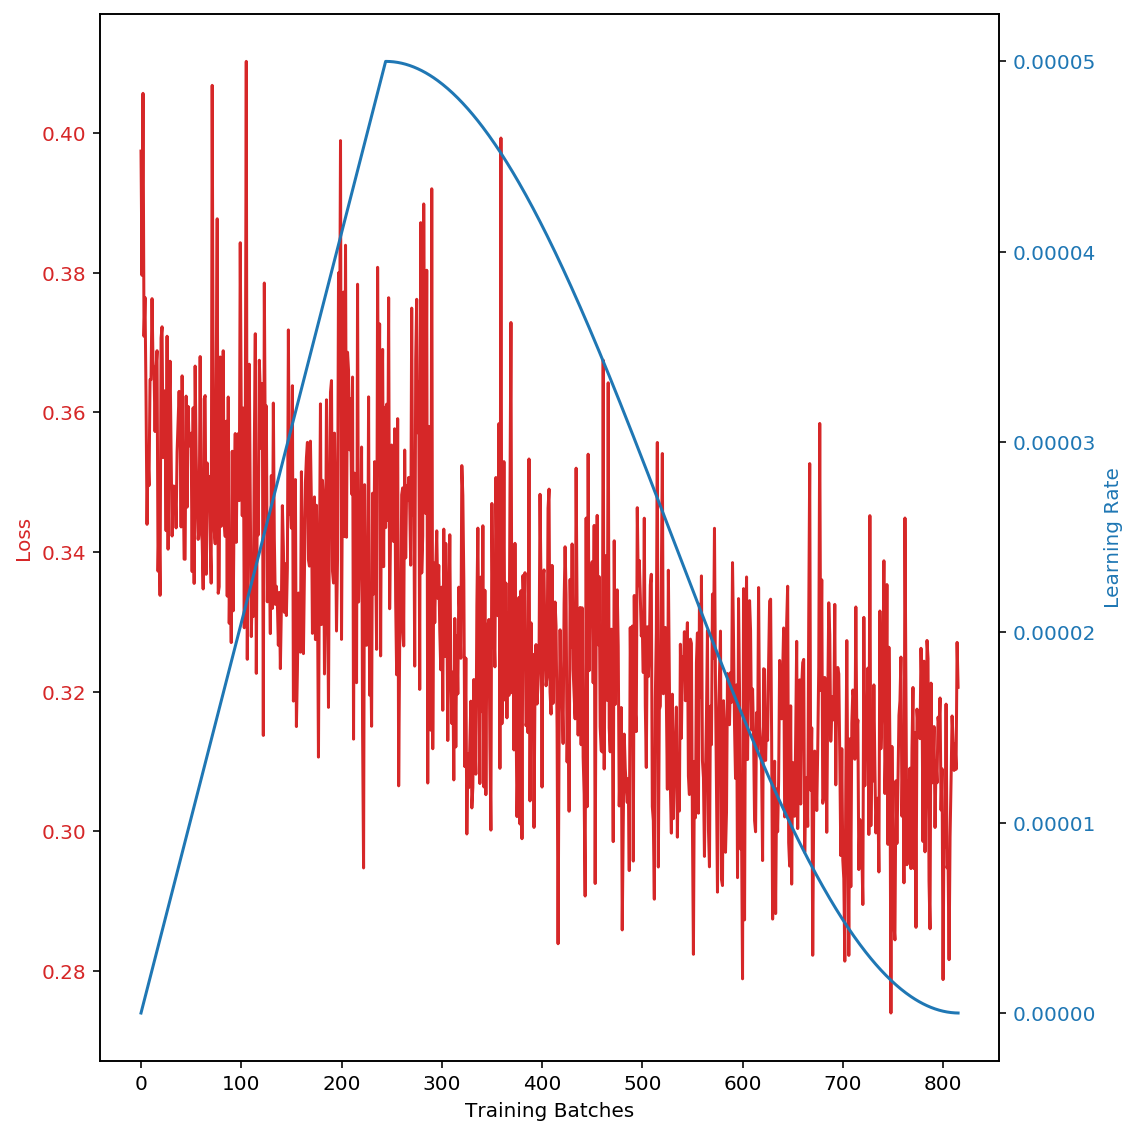

Proba       Preds    
         min   max   min max
Labels                      
0      0.065 0.782     0   1
1      0.202 0.782     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.434,"[0.5658804774284363, 0.4341195225715637]",0,1,0.464,"[0.5359491109848022, 0.46405094861984253]",0,1,0.485,"[0.5145135521888733, 0.4854864478111267]",0,1
1,0.371,"[0.6294471025466919, 0.3705528974533081]",0,0,0.549,"[0.45109665393829346, 0.5489033460617065]",1,1,0.382,"[0.6176016926765442, 0.3823983073234558]",0,1
2,0.203,"[0.7966785430908203, 0.20332147181034088]",0,1,0.413,"[0.5868078470230103, 0.41319209337234497]",0,1,0.570,"[0.42993733286857605, 0.5700626373291016]",1,0
3,0.458,"[0.5415877103805542, 0.4584122598171234]",0,0,0.653,"[0.34689730405807495, 0.653102695941925]",1,0,0.362,"[0.6383525729179382, 0.3616473972797394]",0,1
4,0.565,"[0.4351670742034912, 0.5648329257965088]",1,1,0.458,"[0.5415877103805542, 0.4584122598171234]",0,0,0.664,"[0.33559268712997437, 0.6644073724746704]",1,0


scores =  {'map': '0.6097', 'acc': '0.5880', 'auc': '0.6440'}


train   val
mean_or_std metric               
mean        map       0.769 0.610
            accuracy  0.768 0.588
            auc       0.848 0.644
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.841  0.788 0.813 5450.000     0.571  0.708 0.632 250.000
pos     0.659  0.733 0.694 3050.000     0.616  0.468 0.532 250.000

In [26]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.025,
                              dropout=0.025,
                              word_masking_proba=0.15, # 0.1
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[9, 17, 27, 37, 44, 54],
    show_model_stats=False,
    sampling_policy="without_replacement",
    prediction_iters=5, evaluate_in_train_mode=True
)
r2, p2 = results, prfs
results
prfs


In [17]:
# reg_scheduling and multi-eval won't work together
# All regularization bound by if self.training

2

## Decoder Ensemble

Pick stored Model ./distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4250 Batch Size =  256
Training Samples =  8500 Weighted Sampling =  True Num Batches =  17 Accumulation steps =  1



Epoch =  1 Loss = 0.825098 LR = 0.00000697



Epoch =  2 Loss = 0.645896 LR = 0.00001393



Epoch =  3 Loss = 0.574671 LR = 0.00002090



Epoch =  4 Loss = 0.543297 LR = 0.00002787


Proba       Preds    
         min   max   min max
Labels                      
0      0.367 0.473     0   0
1      0.368 0.473     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.400,"[0.6000945568084717, 0.39990541338920593]",0,0,0.385,"[0.6153837442398071, 0.38461625576019287]",0,0,0.417,"[0.5828951597213745, 0.4171048700809479]",0,1
1,0.402,"[0.5981106758117676, 0.4018893241882324]",0,1,0.402,"[0.5980411767959595, 0.40195876359939575]",0,1,0.441,"[0.5585863590240479, 0.44141364097595215]",0,1
2,0.406,"[0.5943883657455444, 0.40561163425445557]",0,0,0.381,"[0.6185457706451416, 0.381454199552536]",0,0,0.426,"[0.5735257863998413, 0.4264742136001587]",0,1
3,0.405,"[0.5945001244544983, 0.4054998457431793]",0,1,0.418,"[0.5816152691841125, 0.41838473081588745]",0,1,0.407,"[0.5931220650672913, 0.40687787532806396]",0,0
4,0.426,"[0.5740940570831299, 0.4259059727191925]",0,0,0.420,"[0.5800891518592834, 0.41991090774536133]",0,1,0.406,"[0.5943644046783447, 0.4056355953216553]",0,1


scores =  {'map': '0.5457', 'acc': '0.5000', 'auc': '0.5529'}
Epoch =  4 Train = 0.642595 Val = 0.552904



Epoch =  5 Loss = 0.528677 LR = 0.00003484



Epoch =  6 Loss = 0.518939 LR = 0.00004180



Epoch =  7 Loss = 0.514026 LR = 0.00004877


Proba       Preds    
         min   max   min max
Labels                      
0      0.298 0.526     0   1
1      0.342 0.532     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.420,"[0.5802394151687622, 0.4197605550289154]",0,1,0.496,"[0.5043643712997437, 0.49563562870025635]",0,1,0.485,"[0.5147221088409424, 0.4852779507637024]",0,0
1,0.375,"[0.6249499320983887, 0.37505006790161133]",0,0,0.420,"[0.5800890326499939, 0.4199109375476837]",0,0,0.427,"[0.5728524327278137, 0.4271475672721863]",0,1
2,0.412,"[0.5878139734268188, 0.41218602657318115]",0,0,0.414,"[0.5859416723251343, 0.4140583276748657]",0,0,0.429,"[0.5714441537857056, 0.4285558760166168]",0,1
3,0.421,"[0.5787840485572815, 0.4212159514427185]",0,0,0.478,"[0.5221962332725525, 0.4778037667274475]",0,1,0.400,"[0.6000701189041138, 0.39992988109588623]",0,1
4,0.442,"[0.5578620433807373, 0.4421379566192627]",0,0,0.476,"[0.5237613916397095, 0.47623854875564575]",0,0,0.435,"[0.564543604850769, 0.43545636534690857]",0,1


scores =  {'map': '0.5839', 'acc': '0.5100', 'auc': '0.6045'}
Epoch =  7 Train = 0.713388 Val = 0.604456



Epoch =  8 Loss = 0.502605 LR = 0.00005574



Epoch =  9 Loss = 0.495395 LR = 0.00006270


Proba       Preds    
         min   max   min max
Labels                      
0      0.299 0.536     0   1
1      0.365 0.536     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.407,"[0.592573881149292, 0.407426118850708]",0,0,0.429,"[0.5705748796463013, 0.42942512035369873]",0,1,0.513,"[0.48718690872192383, 0.5128130912780762]",1,0
1,0.412,"[0.5884096026420593, 0.4115903973579407]",0,0,0.450,"[0.549726665019989, 0.450273334980011]",0,0,0.368,"[0.6315464973449707, 0.3684535622596741]",0,0
2,0.452,"[0.5483077764511108, 0.45169225335121155]",0,1,0.463,"[0.5365434885025024, 0.46345657110214233]",0,1,0.461,"[0.5393917560577393, 0.46060821413993835]",0,0
3,0.442,"[0.557719886302948, 0.442280113697052]",0,1,0.422,"[0.5783543586730957, 0.4216456413269043]",0,0,0.423,"[0.5769619941711426, 0.4230380058288574]",0,0
4,0.501,"[0.4986051917076111, 0.5013948082923889]",1,0,0.408,"[0.591607391834259, 0.40839260816574097]",0,1,0.432,"[0.5678102374076843, 0.4321897625923157]",0,0


scores =  {'map': '0.5948', 'acc': '0.5080', 'auc': '0.6160'}
Epoch =  9 Train = 0.739943 Val = 0.615976



Epoch =  10 Loss = 0.496655 LR = 0.00006967



Epoch =  11 Loss = 0.487136 LR = 0.00007664


Proba       Preds    
         min   max   min max
Labels                      
0      0.280 0.470     0   0
1      0.330 0.476     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.390,"[0.6095772981643677, 0.3904227018356323]",0,1,0.416,"[0.5835922360420227, 0.4164077341556549]",0,0,0.369,"[0.6305584907531738, 0.36944150924682617]",0,0
1,0.395,"[0.6054102182388306, 0.39458978176116943]",0,0,0.410,"[0.5897958874702454, 0.41020408272743225]",0,1,0.454,"[0.545806348323822, 0.454193651676178]",0,0
2,0.430,"[0.5702168941497803, 0.4297831058502197]",0,1,0.404,"[0.5958451628684998, 0.40415483713150024]",0,0,0.372,"[0.6282511353492737, 0.3717488944530487]",0,0
3,0.373,"[0.6265984773635864, 0.3734014630317688]",0,0,0.390,"[0.6101253032684326, 0.3898746967315674]",0,1,0.357,"[0.6430834531784058, 0.35691654682159424]",0,0
4,0.435,"[0.564774751663208, 0.4352252185344696]",0,0,0.439,"[0.5608832836151123, 0.4391167163848877]",0,1,0.351,"[0.6488631963729858, 0.35113683342933655]",0,0


scores =  {'map': '0.5973', 'acc': '0.5000', 'auc': '0.6106'}
Epoch =  11 Train = 0.752349 Val = 0.610568



Epoch =  12 Loss = 0.483497 LR = 0.00008361



Epoch =  13 Loss = 0.486319 LR = 0.00009057



Epoch =  14 Loss = 0.492862 LR = 0.00009754


Proba       Preds    
         min   max   min max
Labels                      
0      0.254 0.474     0   0
1      0.321 0.496     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.421,"[0.5793059468269348, 0.4206939935684204]",0,1,0.439,"[0.5614545345306396, 0.4385455250740051]",0,1,0.345,"[0.6551902294158936, 0.34480977058410645]",0,0
1,0.403,"[0.5974583625793457, 0.4025416374206543]",0,1,0.410,"[0.5900934934616089, 0.4099065065383911]",0,0,0.385,"[0.6152442693710327, 0.3847557008266449]",0,1
2,0.408,"[0.5921034812927246, 0.407896488904953]",0,0,0.379,"[0.6210393905639648, 0.37896063923835754]",0,1,0.448,"[0.5520352125167847, 0.44796478748321533]",0,1
3,0.391,"[0.6093196868896484, 0.39068037271499634]",0,0,0.391,"[0.608833909034729, 0.3911661207675934]",0,1,0.369,"[0.6308984756469727, 0.36910155415534973]",0,1
4,0.400,"[0.6000285148620605, 0.39997148513793945]",0,1,0.402,"[0.5980679988861084, 0.401932030916214]",0,0,0.423,"[0.5772815942764282, 0.4227184057235718]",0,1


scores =  {'map': '0.5819', 'acc': '0.5000', 'auc': '0.6109'}
Epoch =  14 Train = 0.752583 Val = 0.610904



Epoch =  15 Loss = 0.478658 LR = 0.00009991



Epoch =  16 Loss = 0.483169 LR = 0.00009941



Epoch =  17 Loss = 0.481298 LR = 0.00009848


Proba       Preds    
         min   max   min max
Labels                      
0      0.242 0.534     0   1
1      0.310 0.534     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.426,"[0.5744381546974182, 0.4255618453025818]",0,1,0.470,"[0.5300424098968506, 0.4699576199054718]",0,1,0.511,"[0.4886360168457031, 0.5113639831542969]",1,1
1,0.438,"[0.5620801448822021, 0.43791982531547546]",0,0,0.468,"[0.5324897170066833, 0.4675102233886719]",0,1,0.436,"[0.5637885928153992, 0.43621140718460083]",0,0
2,0.426,"[0.5736509561538696, 0.42634907364845276]",0,1,0.409,"[0.5909866690635681, 0.4090133309364319]",0,0,0.529,"[0.47058194875717163, 0.5294180512428284]",1,0
3,0.416,"[0.5841505527496338, 0.415849506855011]",0,1,0.440,"[0.5595637559890747, 0.4404362440109253]",0,0,0.528,"[0.47241348028182983, 0.5275865197181702]",1,0
4,0.469,"[0.5309200882911682, 0.4690799117088318]",0,1,0.418,"[0.5821515321731567, 0.41784852743148804]",0,0,0.452,"[0.5479861497879028, 0.4520138204097748]",0,1


scores =  {'map': '0.5987', 'acc': '0.5320', 'auc': '0.6340'}
Epoch =  17 Train = 0.782744 Val = 0.633992



Epoch =  18 Loss = 0.472745 LR = 0.00009713



Epoch =  19 Loss = 0.467528 LR = 0.00009537


Proba       Preds    
         min   max   min max
Labels                      
0      0.112 0.552     0   1
1      0.205 0.552     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.386,"[0.6144185066223145, 0.38558149337768555]",0,0,0.444,"[0.5562803149223328, 0.44371968507766724]",0,0,0.390,"[0.610306441783905, 0.3896934986114502]",0,0
1,0.422,"[0.57750403881073, 0.42249593138694763]",0,1,0.371,"[0.6285915374755859, 0.37140846252441406]",0,1,0.374,"[0.6262048482894897, 0.37379521131515503]",0,0
2,0.479,"[0.5207474231719971, 0.47925254702568054]",0,1,0.479,"[0.5206669569015503, 0.4793330430984497]",0,1,0.445,"[0.5545477867126465, 0.4454522132873535]",0,1
3,0.444,"[0.5564906001091003, 0.44350939989089966]",0,0,0.505,"[0.49465054273605347, 0.5053494572639465]",1,0,0.443,"[0.5571738481521606, 0.44282615184783936]",0,1
4,0.453,"[0.5473753213882446, 0.45262467861175537]",0,1,0.368,"[0.6317079663276672, 0.36829203367233276]",0,1,0.474,"[0.5263757705688477, 0.47362422943115234]",0,1


scores =  {'map': '0.5810', 'acc': '0.5100', 'auc': '0.6228'}
Epoch =  19 Train = 0.793977 Val = 0.622792



Epoch =  20 Loss = 0.469692 LR = 0.00009321



Epoch =  21 Loss = 0.470404 LR = 0.00009068



Epoch =  22 Loss = 0.467867 LR = 0.00008779



Epoch =  23 Loss = 0.470881 LR = 0.00008457


Proba       Preds    
         min   max   min max
Labels                      
0      0.190 0.456     0   0
1      0.239 0.457     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.379,"[0.6212131977081299, 0.3787868022918701]",0,0,0.415,"[0.5851757526397705, 0.4148242473602295]",0,1,0.409,"[0.5910695195198059, 0.4089304506778717]",0,1
1,0.401,"[0.5989573001861572, 0.4010426998138428]",0,1,0.390,"[0.6100329160690308, 0.3899671137332916]",0,0,0.391,"[0.6089495420455933, 0.39105042815208435]",0,0
2,0.407,"[0.592668890953064, 0.40733104944229126]",0,0,0.411,"[0.5889946222305298, 0.4110053479671478]",0,1,0.403,"[0.5965722799301147, 0.40342772006988525]",0,0
3,0.420,"[0.5795732140541077, 0.42042678594589233]",0,1,0.435,"[0.5651326179504395, 0.43486741185188293]",0,0,0.415,"[0.5851686000823975, 0.41483134031295776]",0,1
4,0.334,"[0.6659610867500305, 0.3340389132499695]",0,0,0.444,"[0.5562049746513367, 0.4437950551509857]",0,0,0.396,"[0.6043424606323242, 0.3956575095653534]",0,1


scores =  {'map': '0.6066', 'acc': '0.5000', 'auc': '0.6370'}
Epoch =  23 Train = 0.807510 Val = 0.637048



Epoch =  24 Loss = 0.462486 LR = 0.00008105



Epoch =  25 Loss = 0.463121 LR = 0.00007726



Epoch =  26 Loss = 0.463304 LR = 0.00007324



Epoch =  27 Loss = 0.461171 LR = 0.00006901


Proba       Preds    
         min   max   min max
Labels                      
0      0.090 0.448     0   0
1      0.129 0.449     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.394,"[0.6063394546508789, 0.3936605453491211]",0,1,0.415,"[0.5848050713539124, 0.41519492864608765]",0,1,0.174,"[0.8259727954864502, 0.1740272045135498]",0,0
1,0.355,"[0.6451596021652222, 0.35484039783477783]",0,0,0.407,"[0.5927472710609436, 0.4072527587413788]",0,0,0.237,"[0.7629009485244751, 0.2370990663766861]",0,0
2,0.328,"[0.672205924987793, 0.32779404520988464]",0,0,0.285,"[0.7150153517723083, 0.28498464822769165]",0,1,0.397,"[0.6028529405593872, 0.3971470296382904]",0,1
3,0.390,"[0.6099593043327332, 0.39004066586494446]",0,0,0.363,"[0.6372870206832886, 0.3627130091190338]",0,1,0.327,"[0.6728334426879883, 0.32716652750968933]",0,0
4,0.332,"[0.6680387854576111, 0.3319612145423889]",0,0,0.425,"[0.5745916366577148, 0.42540833353996277]",0,1,0.408,"[0.5922638773918152, 0.4077360928058624]",0,1


scores =  {'map': '0.6037', 'acc': '0.5000', 'auc': '0.6393'}
Epoch =  27 Train = 0.824353 Val = 0.639304



Epoch =  28 Loss = 0.467099 LR = 0.00006461



Epoch =  29 Loss = 0.459498 LR = 0.00006009



Epoch =  30 Loss = 0.458401 LR = 0.00005548



Epoch =  31 Loss = 0.458091 LR = 0.00005082


Proba       Preds    
         min   max   min max
Labels                      
0      0.037 0.509     0   1
1      0.062 0.500     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.168,"[0.8319038152694702, 0.16809618473052979]",0,0,0.225,"[0.7746517658233643, 0.22534820437431335]",0,1,0.455,"[0.5448140501976013, 0.45518597960472107]",0,1
1,0.457,"[0.5434167385101318, 0.4565832316875458]",0,1,0.466,"[0.5336859822273254, 0.46631401777267456]",0,0,0.398,"[0.6023819446563721, 0.3976180851459503]",0,0
2,0.449,"[0.5509703159332275, 0.44902971386909485]",0,0,0.439,"[0.5614856481552124, 0.4385143518447876]",0,1,0.352,"[0.6478704810142517, 0.3521295189857483]",0,0
3,0.461,"[0.538793683052063, 0.46120622754096985]",0,0,0.251,"[0.7494940757751465, 0.2505059242248535]",0,0,0.451,"[0.5492171049118042, 0.4507828652858734]",0,0
4,0.453,"[0.5470227003097534, 0.4529772996902466]",0,1,0.432,"[0.5678631067276001, 0.4321368932723999]",0,1,0.433,"[0.567065954208374, 0.432934045791626]",0,0


scores =  {'map': '0.5878', 'acc': '0.5000', 'auc': '0.6369'}
Epoch =  31 Train = 0.834604 Val = 0.636936



Epoch =  32 Loss = 0.454717 LR = 0.00004616



Epoch =  33 Loss = 0.457907 LR = 0.00004153



Epoch =  34 Loss = 0.455820 LR = 0.00003697


Proba       Preds    
         min   max   min max
Labels                      
0      0.149 0.531     0   1
1      0.181 0.552     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.466,"[0.5344077348709106, 0.46559229493141174]",0,0,0.446,"[0.553673267364502, 0.44632673263549805]",0,1,0.449,"[0.5513861179351807, 0.44861382246017456]",0,0
1,0.267,"[0.7327166199684143, 0.2672833800315857]",0,0,0.396,"[0.6042191982269287, 0.3957808315753937]",0,1,0.503,"[0.49652907252311707, 0.5034708976745605]",1,0
2,0.433,"[0.567278265953064, 0.4327217936515808]",0,0,0.334,"[0.6660118103027344, 0.3339881896972656]",0,1,0.295,"[0.7045407891273499, 0.29545921087265015]",0,0
3,0.460,"[0.540385365486145, 0.45961466431617737]",0,1,0.488,"[0.512367308139801, 0.487632691860199]",0,0,0.315,"[0.6845744848251343, 0.3154255151748657]",0,1
4,0.473,"[0.5272260904312134, 0.47277384996414185]",0,1,0.516,"[0.4836903512477875, 0.5163096785545349]",1,0,0.311,"[0.6891961097717285, 0.31080394983291626]",0,1


scores =  {'map': '0.6021', 'acc': '0.5320', 'auc': '0.6435'}
Epoch =  34 Train = 0.840172 Val = 0.643544



Epoch =  35 Loss = 0.448771 LR = 0.00003253



Epoch =  36 Loss = 0.451330 LR = 0.00002824



Epoch =  37 Loss = 0.448327 LR = 0.00002413


Proba       Preds    
         min   max   min max
Labels                      
0      0.033 0.492     0   0
1      0.042 0.494     0   0

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.141,"[0.8594110012054443, 0.1405889391899109]",0,0,0.369,"[0.6314874887466431, 0.3685125410556793]",0,0,0.248,"[0.751669704914093, 0.24833029508590698]",0,0
1,0.414,"[0.5857557654380798, 0.41424426436424255]",0,1,0.471,"[0.5292710065841675, 0.4707289934158325]",0,1,0.448,"[0.5518244504928589, 0.44817548990249634]",0,1
2,0.424,"[0.5755685567855835, 0.4244315028190613]",0,0,0.458,"[0.5415646433830261, 0.4584353566169739]",0,1,0.390,"[0.609891414642334, 0.390108585357666]",0,1
3,0.413,"[0.5866910219192505, 0.4133089482784271]",0,1,0.330,"[0.6695516109466553, 0.3304484188556671]",0,0,0.428,"[0.5723395347595215, 0.4276605248451233]",0,1
4,0.269,"[0.7305426597595215, 0.2694573700428009]",0,0,0.351,"[0.6490057706832886, 0.3509942293167114]",0,1,0.471,"[0.5292710065841675, 0.4707289934158325]",0,1


scores =  {'map': '0.6072', 'acc': '0.5000', 'auc': '0.6489'}
Epoch =  37 Train = 0.846040 Val = 0.648888



Epoch =  38 Loss = 0.452470 LR = 0.00002026



Epoch =  39 Loss = 0.450696 LR = 0.00001664



Epoch =  40 Loss = 0.450273 LR = 0.00001331



Epoch =  41 Loss = 0.449442 LR = 0.00001030


Proba       Preds    
         min   max   min max
Labels                      
0      0.007 0.536     0   1
1      0.008 0.538     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.516,"[0.48431938886642456, 0.5156805515289307]",1,0,0.447,"[0.5534967184066772, 0.44650328159332275]",0,1,0.476,"[0.5240148901939392, 0.4759851098060608]",0,1
1,0.473,"[0.5267197489738464, 0.4732802212238312]",0,1,0.421,"[0.5787713527679443, 0.42122864723205566]",0,1,0.220,"[0.7799796462059021, 0.2200203686952591]",0,0
2,0.351,"[0.6487204432487488, 0.3512795865535736]",0,0,0.039,"[0.961204469203949, 0.03879553824663162]",0,0,0.507,"[0.49277347326278687, 0.5072265267372131]",1,1
3,0.215,"[0.7851301431655884, 0.21486985683441162]",0,0,0.352,"[0.6479186415672302, 0.3520813584327698]",0,1,0.261,"[0.7386264801025391, 0.2613735795021057]",0,0
4,0.305,"[0.6951888799667358, 0.30481114983558655]",0,0,0.493,"[0.5070685148239136, 0.4929314851760864]",0,0,0.508,"[0.49165356159210205, 0.508346438407898]",1,0


scores =  {'map': '0.6055', 'acc': '0.5220', 'auc': '0.6468'}
Epoch =  41 Train = 0.852030 Val = 0.646776



Epoch =  42 Loss = 0.442624 LR = 0.00000764



Epoch =  43 Loss = 0.449945 LR = 0.00000535



Epoch =  44 Loss = 0.444062 LR = 0.00000345


Proba       Preds    
         min   max   min max
Labels                      
0      0.005 0.544     0   1
1      0.005 0.546     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.467,"[0.5332367420196533, 0.4667632579803467]",0,0,0.473,"[0.527170717716217, 0.47282928228378296]",0,0,0.499,"[0.5009151697158813, 0.49908480048179626]",0,0
1,0.488,"[0.5117480158805847, 0.4882519543170929]",0,1,0.498,"[0.5023871660232544, 0.4976128339767456]",0,1,0.507,"[0.49266737699508667, 0.5073326230049133]",1,0
2,0.458,"[0.5424860715866089, 0.4575139582157135]",0,0,0.494,"[0.5059670209884644, 0.49403297901153564]",0,1,0.525,"[0.4754680097103119, 0.5245320200920105]",1,0
3,0.475,"[0.5253366231918335, 0.4746634364128113]",0,1,0.529,"[0.4709714651107788, 0.5290285348892212]",1,1,0.198,"[0.8019843101501465, 0.19801566004753113]",0,0
4,0.505,"[0.4950425326824188, 0.5049574375152588]",1,1,0.376,"[0.6236120462417603, 0.37638789415359497]",0,0,0.493,"[0.506958544254303, 0.493041455745697]",0,1


scores =  {'map': '0.6056', 'acc': '0.5520', 'auc': '0.6470'}
Epoch =  44 Train = 0.853793 Val = 0.647048



Epoch =  45 Loss = 0.444019 LR = 0.00000195



Epoch =  46 Loss = 0.446247 LR = 0.00000087



Epoch =  47 Loss = 0.446875 LR = 0.00000022


Proba       Preds    
         min   max   min max
Labels                      
0      0.005 0.544     0   1
1      0.005 0.546     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.063,"[0.9371981024742126, 0.06280190497636795]",0,0,0.192,"[0.8081372380256653, 0.19186276197433472]",0,0,0.229,"[0.7705118656158447, 0.22948819398880005]",0,0
1,0.410,"[0.5902296304702759, 0.4097703695297241]",0,0,0.127,"[0.873375415802002, 0.12662461400032043]",0,0,0.125,"[0.8751279711723328, 0.12487202137708664]",0,0
2,0.345,"[0.6551599502563477, 0.34484007954597473]",0,0,0.494,"[0.506129264831543, 0.49387067556381226]",0,0,0.463,"[0.5374051928520203, 0.46259480714797974]",0,1
3,0.491,"[0.5086734294891357, 0.49132657051086426]",0,0,0.414,"[0.5861639976501465, 0.4138360023498535]",0,0,0.457,"[0.5432940125465393, 0.4567059874534607]",0,1
4,0.517,"[0.4828543961048126, 0.5171456336975098]",1,1,0.507,"[0.49255114793777466, 0.5074488520622253]",1,1,0.418,"[0.5823034048080444, 0.41769659519195557]",0,1


scores =  {'map': '0.6050', 'acc': '0.5340', 'auc': '0.6464'}
Epoch =  47 Train = 0.854135 Val = 0.646408



Epoch =  48 Loss = 0.449241 LR = 0.00000000



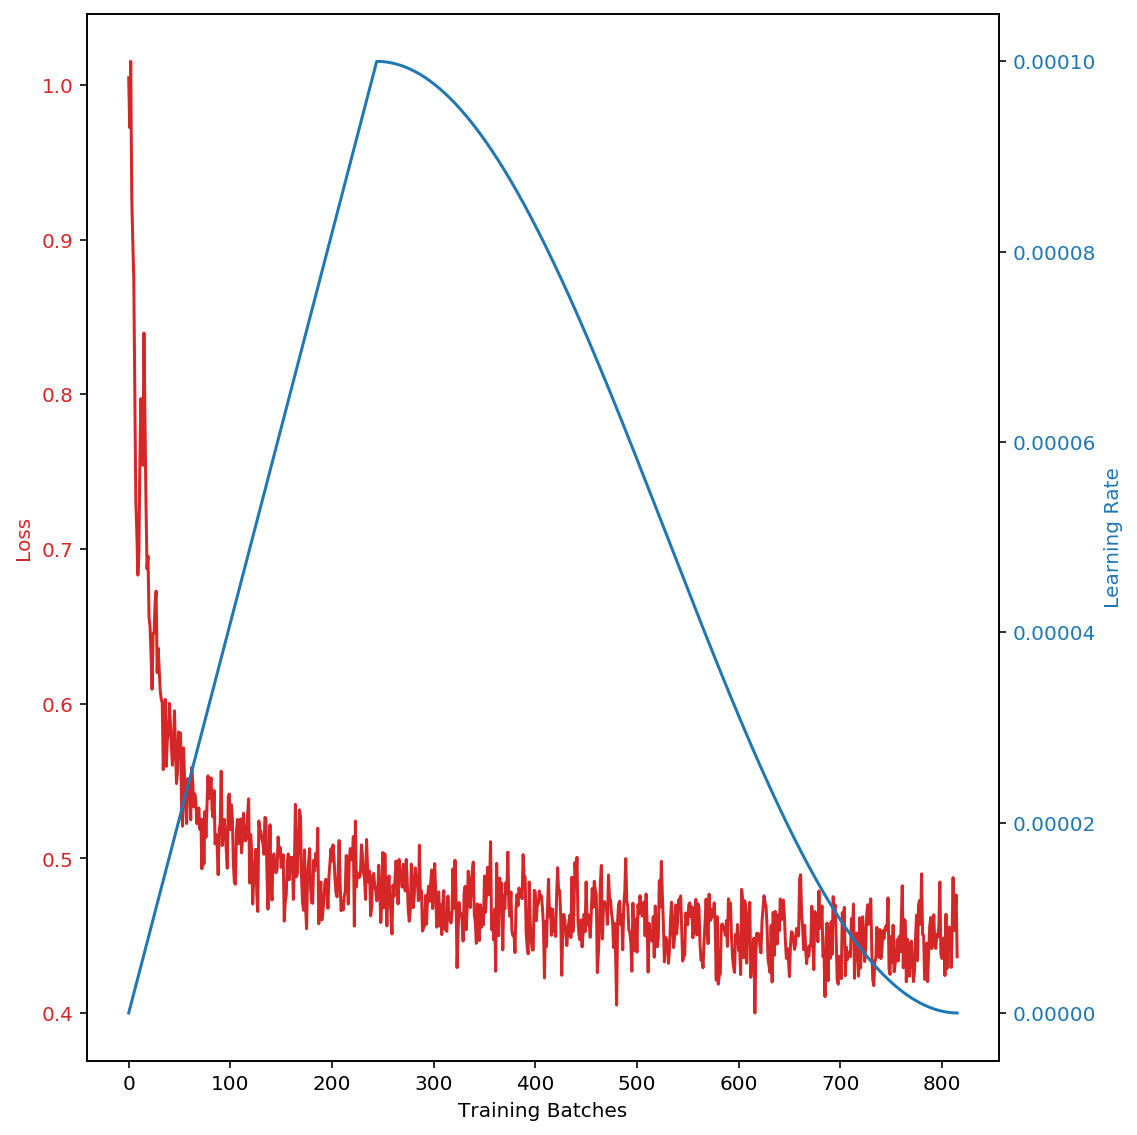

Proba       Preds    
         min   max   min max
Labels                      
0      0.005 0.544     0   1
1      0.005 0.546     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.495,"[0.5046037435531616, 0.49539628624916077]",0,1,0.463,"[0.5367630124092102, 0.4632369875907898]",0,0,0.484,"[0.5156912207603455, 0.48430877923965454]",0,0
1,0.467,"[0.5331155061721802, 0.4668845236301422]",0,1,0.058,"[0.9424941539764404, 0.05750580132007599]",0,0,0.479,"[0.5214051008224487, 0.47859495878219604]",0,1
2,0.478,"[0.5215041041374207, 0.47849589586257935]",0,1,0.464,"[0.5359055995941162, 0.4640944004058838]",0,1,0.498,"[0.501842200756073, 0.498157799243927]",0,1
3,0.504,"[0.49577391147613525, 0.5042260885238647]",1,0,0.478,"[0.5221670269966125, 0.47783297300338745]",0,0,0.462,"[0.5375398993492126, 0.46246013045310974]",0,1
4,0.449,"[0.5512950420379639, 0.4487049877643585]",0,0,0.436,"[0.5644972324371338, 0.4355027675628662]",0,0,0.203,"[0.7974177598953247, 0.20258229970932007]",0,0


scores =  {'map': '0.6052', 'acc': '0.5340', 'auc': '0.6466'}


train   val
mean_or_std metric               
mean        map       0.764 0.605
            accuracy  0.772 0.534
            auc       0.854 0.647
std         map       0.000 0.000
            accuracy  0.000 0.000
            auc       0.000 0.000

train                             val                     
    precision recall    f1  supoort precision recall    f1 supoort
neg     0.773  0.912 0.837 5450.000     0.520  0.884 0.655 250.000
pos     0.769  0.520 0.620 3050.000     0.613  0.184 0.283 250.000

In [21]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.1,
                              dropout=0.15,
                              word_masking_proba=0.2,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False,
                              n_classifier_layers=1,
                              n_classifier_decoders=4,
                             ),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[1, 4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=True,
    sampling_policy="without_replacement",
    prediction_iters=1, evaluate_in_train_mode=False
)
r2, p2 = results, prfs
results
prfs


In [ ]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=1e-4, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-2)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"] / 1e3,
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=256,
                              num_classes=2,
                              gaussian_noise=0.1,
                              dropout=0.01,
                              word_masking_proba=0.1,
                              internal_dims=512,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=3,
                              n_decoders=0,
                              n_tokens_in=96,
                              n_tokens_out=48,
                              featurizer="transformer",
                              model='distilbert-cor-nsp',
                              loss="focal",
                              classification_head="decoder_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=1.0,
                              attention_drop_proba=0.05,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)

kfold = False
results, prfs = train_validate_ntimes(
    model_fn,
    data,
    batch_size,
    epochs,
    kfold=kfold,
    scheduler_init_fn=scheduler_init_fn,
    model_call_back=reg_sched, # reg_sched
    validation_epochs=[4, 7, 9, 11, 14, 17, 19, 23, 27, 31, 34, 37, 41, 44, 47, 51, 54],
    show_model_stats=False,
    sampling_policy="without_replacement")
r2, p2 = results, prfs
results
prfs



# Predict

In [7]:
adamw = torch.optim.AdamW
adamw_params = dict(lr=5e-5, betas=(0.9, 0.98), eps=1e-08, weight_decay=1e-3)
optimizer = adamw
optimizer_params = adamw_params

lr_strategy = {
    "model": {
        "lr": optimizer_params["lr"] / 1000,
        "finetune": False,
        "encoder": {
            "layer": {
                "2": {
                    "lr": optimizer_params["lr"],
                    "finetune": False
                },
                "3": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "4": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                },
                "5": {
                    "lr": optimizer_params["lr"],
                    "finetune": True
                }
            }
        },
    }
}

epochs = 24
batch_size = 256
model_fn = model_builder(AlbertClassifer,
                         dict(classifier_dims=768,
                              num_classes=2,
                              gaussian_noise=0.1,
                              dropout=0.15,
                              word_masking_proba=0.2,
                              internal_dims=768,
                              final_layer_builder=fb_1d_loss_builder,
                              n_layers=2,
                              n_encoders=0,
                              n_decoders=1,
                              n_tokens_in=96,
                              n_tokens_out=16,
                              featurizer="transformer",
                              model='distilbert-nsp',
                              loss="focal",
                              classification_head="head_ensemble", # head_ensemble
                              dice_loss_coef=0.0,
                              auc_loss_coef=0.5, # 0.1
                              attention_drop_proba=0.0,
                              finetune=False),
                         per_param_opts_fn=lr_strategy,
                         optimiser_class=optimizer,
                         optimiser_params=optimizer_params)


Pick stored Model /home/ahemf/cache/distilbert-nsp Model Class =  <class 'transformers.modeling_roberta.RobertaModel'> Tokenizer Class =  <class 'transformers.tokenization_roberta.RobertaTokenizer'>
Autocast =  True Epochs =  48 Divisor = 2 Examples = 4500 Batch Size =  256
Training Samples =  9000 Weighted Sampling =  True Num Batches =  18 Accumulation steps =  1



Epoch =  1 Loss = 0.663660 LR = 0.00000347



Epoch =  2 Loss = 0.634494 LR = 0.00000695



Epoch =  3 Loss = 0.617023 LR = 0.00001042



Epoch =  4 Loss = 0.600699 LR = 0.00001390



Epoch =  5 Loss = 0.587276 LR = 0.00001737



Epoch =  6 Loss = 0.569610 LR = 0.00002085



Epoch =  7 Loss = 0.548532 LR = 0.00002432



Epoch =  8 Loss = 0.542661 LR = 0.00002780



Epoch =  9 Loss = 0.517081 LR = 0.00003127



Epoch =  10 Loss = 0.492819 LR = 0.00003475



Epoch =  11 Loss = 0.499571 LR = 0.00003822



Epoch =  12 Loss = 0.469825 LR = 0.00004170



Epoch =  13 Loss = 0.476830 LR = 0.00004517



Epoch =  14 Loss = 0.475851 LR = 0.00004865



Epoch =  15 Loss = 0.456779 LR = 0.00004996


Proba       Preds    
         min   max   min max
Labels                      
0      0.105 0.672     0   1
1      0.118 0.715     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.522,"[0.4778052568435669, 0.5221947431564331]",1,0,0.287,"[0.7131957411766052, 0.2868042588233948]",0,1,0.324,"[0.6761518120765686, 0.3238481879234314]",0,0
1,0.291,"[0.7085568904876709, 0.2914431095123291]",0,1,0.438,"[0.5624056458473206, 0.43759435415267944]",0,0,0.264,"[0.735997200012207, 0.26400279998779297]",0,0
2,0.293,"[0.706984281539917, 0.293015718460083]",0,0,0.271,"[0.7287242412567139, 0.2712758183479309]",0,0,0.557,"[0.4428960084915161, 0.5571039915084839]",1,0
3,0.420,"[0.5803751349449158, 0.41962483525276184]",0,1,0.310,"[0.6900472640991211, 0.3099527359008789]",0,1,0.657,"[0.34267985820770264, 0.6573201417922974]",1,0
4,0.707,"[0.2929059863090515, 0.7070940732955933]",1,1,0.360,"[0.6397019624710083, 0.3602980375289917]",0,1,0.626,"[0.3742077052593231, 0.6257923245429993]",1,0


scores =  {'map': '0.5954', 'acc': '0.5260', 'auc': '0.6155'}
Epoch =  15 Train = 0.717039 Val = 0.615496



Epoch =  16 Loss = 0.464869 LR = 0.00004972



Epoch =  17 Loss = 0.447786 LR = 0.00004926



Epoch =  18 Loss = 0.435984 LR = 0.00004859



Epoch =  19 Loss = 0.427589 LR = 0.00004771



Epoch =  20 Loss = 0.431958 LR = 0.00004664



Epoch =  21 Loss = 0.430429 LR = 0.00004538



Epoch =  22 Loss = 0.419423 LR = 0.00004394



Epoch =  23 Loss = 0.413378 LR = 0.00004233



Epoch =  24 Loss = 0.405465 LR = 0.00004057



Epoch =  25 Loss = 0.401952 LR = 0.00003868



Epoch =  26 Loss = 0.401548 LR = 0.00003667



Epoch =  27 Loss = 0.398745 LR = 0.00003455



Epoch =  28 Loss = 0.396507 LR = 0.00003235



Epoch =  29 Loss = 0.395576 LR = 0.00003009



Epoch =  30 Loss = 0.391255 LR = 0.00002779



Epoch =  31 Loss = 0.395508 LR = 0.00002545



Epoch =  32 Loss = 0.389334 LR = 0.00002312



Epoch =  33 Loss = 0.386287 LR = 0.00002080



Epoch =  34 Loss = 0.378357 LR = 0.00001852


Proba       Preds    
         min   max   min max
Labels                      
0      0.185 0.791     0   1
1      0.241 0.822     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.780,"[0.21951517462730408, 0.7804847955703735]",1,1,0.640,"[0.3600619435310364, 0.6399381160736084]",1,1,0.469,"[0.5306167602539062, 0.4693832993507385]",0,1
1,0.628,"[0.37200701236724854, 0.6279929876327515]",1,1,0.369,"[0.6314842700958252, 0.3685157001018524]",0,0,0.289,"[0.7109920382499695, 0.2890079617500305]",0,1
2,0.371,"[0.6290705800056458, 0.37092939019203186]",0,0,0.640,"[0.36036717891693115, 0.6396328210830688]",1,1,0.621,"[0.37868693470954895, 0.6213130950927734]",1,1
3,0.577,"[0.423419713973999, 0.576580286026001]",1,0,0.568,"[0.4324274957180023, 0.5675724744796753]",1,0,0.544,"[0.4555475115776062, 0.5444524884223938]",1,1
4,0.541,"[0.45916008949279785, 0.5408399105072021]",1,0,0.185,"[0.815021812915802, 0.184978187084198]",0,0,0.426,"[0.5735646486282349, 0.42643532156944275]",0,0


scores =  {'map': '0.6494', 'acc': '0.6000', 'auc': '0.6609'}
Epoch =  34 Train = 0.768796 Val = 0.660928



Epoch =  35 Loss = 0.378831 LR = 0.00001629



Epoch =  36 Loss = 0.380753 LR = 0.00001414



Epoch =  37 Loss = 0.385013 LR = 0.00001209



Epoch =  38 Loss = 0.372131 LR = 0.00001015



Epoch =  39 Loss = 0.381673 LR = 0.00000834



Epoch =  40 Loss = 0.366268 LR = 0.00000667



Epoch =  41 Loss = 0.385714 LR = 0.00000516



Epoch =  42 Loss = 0.377686 LR = 0.00000383


Proba       Preds    
         min   max   min max
Labels                      
0      0.045 0.740     0   1
1      0.125 0.804     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.366,"[0.634419858455658, 0.36558014154434204]",0,0,0.599,"[0.40105992555618286, 0.5989401340484619]",1,0,0.415,"[0.5845998525619507, 0.41540008783340454]",0,1
1,0.465,"[0.5353122353553772, 0.464687705039978]",0,0,0.414,"[0.5864332914352417, 0.4135666489601135]",0,1,0.510,"[0.490057110786438, 0.509942889213562]",1,1
2,0.484,"[0.515511155128479, 0.4844888150691986]",0,1,0.468,"[0.5316704511642456, 0.4683295786380768]",0,1,0.360,"[0.6399023532867432, 0.36009764671325684]",0,0
3,0.597,"[0.40302547812461853, 0.5969744920730591]",1,0,0.288,"[0.7116161584854126, 0.2883838415145874]",0,0,0.629,"[0.3708760738372803, 0.6291239261627197]",1,1
4,0.437,"[0.5631700754165649, 0.4368298649787903]",0,0,0.246,"[0.7536891102790833, 0.24631090462207794]",0,0,0.601,"[0.3991946280002594, 0.600805401802063]",1,1


scores =  {'map': '0.6422', 'acc': '0.5880', 'auc': '0.6615'}
Epoch =  42 Train = 0.775946 Val = 0.661544



Epoch =  43 Loss = 0.378372 LR = 0.00000268



Epoch =  44 Loss = 0.375548 LR = 0.00000173



Epoch =  45 Loss = 0.371717 LR = 0.00000098



Epoch =  46 Loss = 0.374816 LR = 0.00000044


Proba       Preds    
         min   max   min max
Labels                      
0      0.055 0.718     0   1
1      0.212 0.809     0   1

,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels,Proba,Probas,Preds,Labels
0,0.273,"[0.7271482348442078, 0.27285176515579224]",0,0,0.394,"[0.6058925986289978, 0.3941074013710022]",0,1,0.387,"[0.6128231287002563, 0.38717690110206604]",0,1
1,0.531,"[0.46917659044265747, 0.5308234095573425]",1,1,0.452,"[0.5479374527931213, 0.4520624876022339]",0,1,0.654,"[0.34582483768463135, 0.6541751623153687]",1,1
2,0.497,"[0.5027844905853271, 0.49721550941467285]",0,1,0.373,"[0.626849889755249, 0.373150110244751]",0,0,0.259,"[0.7407456636428833, 0.2592542767524719]",0,0
3,0.212,"[0.7879893779754639, 0.21201065182685852]",0,1,0.512,"[0.48808547854423523, 0.5119144916534424]",1,0,0.363,"[0.6373913288116455, 0.3626086711883545]",0,1
4,0.302,"[0.6977134346961975, 0.3022865653038025]",0,0,0.497,"[0.5027844905853271, 0.49721550941467285]",0,1,0.585,"[0.41471201181411743, 0.5852879881858826]",1,0


scores =  {'map': '0.6523', 'acc': '0.5880', 'auc': '0.6554'}
Epoch =  46 Train = 0.777533 Val = 0.655368



Epoch =  47 Loss = 0.376497 LR = 0.00000011



Epoch =  48 Loss = 0.371543 LR = 0.00000000



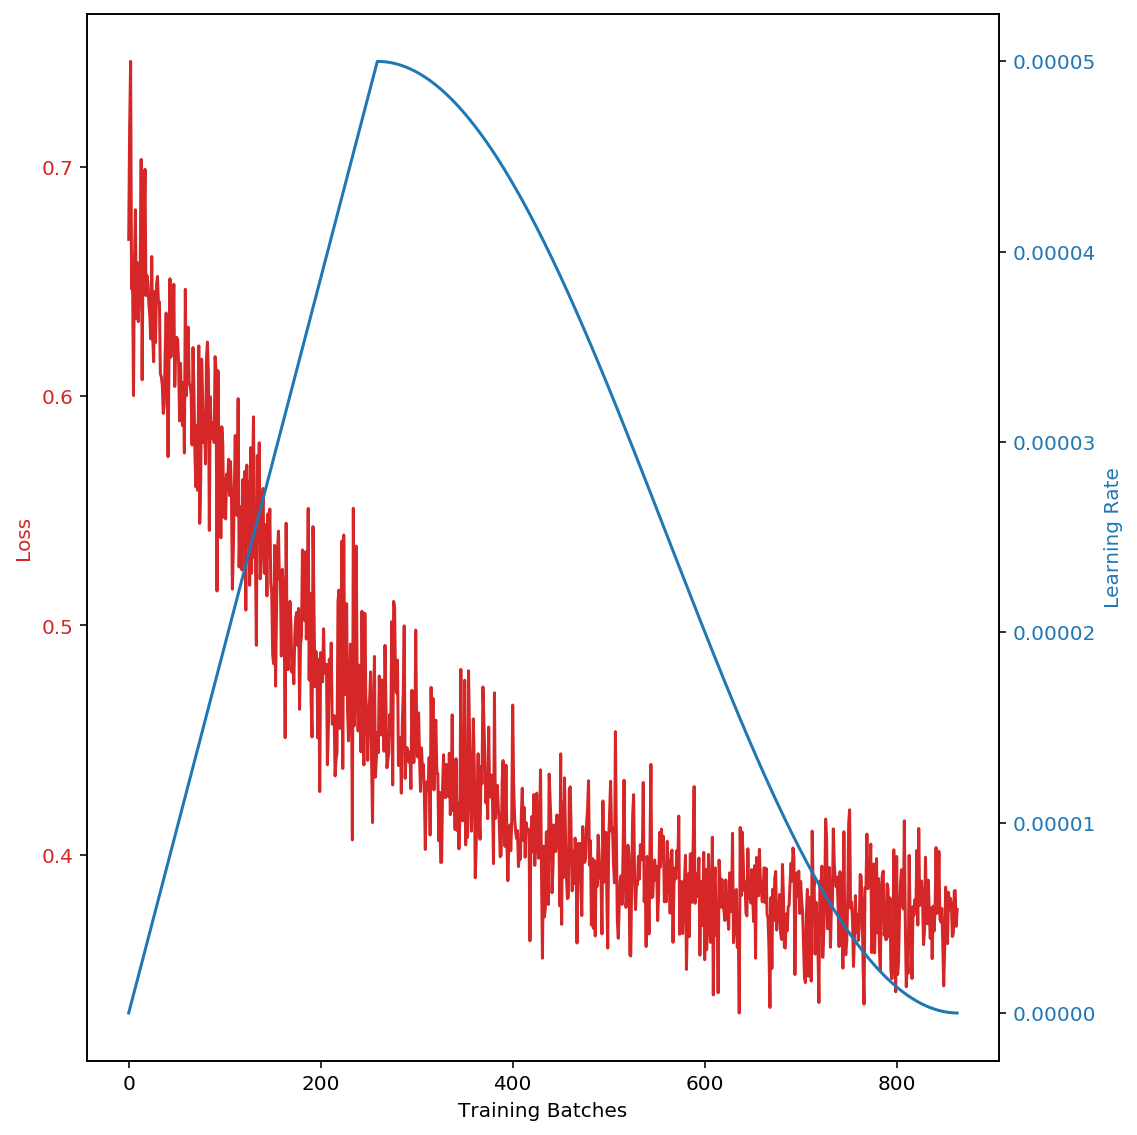

,id,proba,label
666,46503,0.609,1
438,38401,0.653,1
628,18462,0.359,0
493,84325,0.500,1
142,25893,0.366,0


In [8]:
submission, text_model = train_and_predict(model_fn, data, batch_size, epochs, 
                                           scheduler_init_fn=scheduler_init_fn, 
                                           model_call_back=reg_sched,
                                           sampling_policy="without_replacement",
                                           validation_epochs=[15, 34, 42, 46],
                                          )
submission.to_csv("submission.csv",index=False)
submission.sample(5)
